<a href="https://colab.research.google.com/github/mdkamrulhasan/machine_learning_concepts/blob/master/notebooks/supervised/Time_Series_with_RNN_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Adapted from](https://github.com/soham2710/time-series-with-rnn/blob/main/Time_Series_with_RNN.ipynb)

# Time Series with RNN

Case Study: Applying RNNs to Real Data
This case study uses Recurrent Neural Networks (RNNs) to predict sunspots based on historical data. |


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

Data Preprocessing

In [ ]:
import pandas as pd
data_path = "https://raw.githubusercontent.com/mdkamrulhasan/data-public/refs/heads/main/sunspots.csv"
df = pd.read_csv(data_path)


In [ ]:
df = df.drop(columns=['Unnamed: 0'])
df = df.rename(columns={'Monthly Mean Total Sunspot Number': 'monthly_total_sunspots'})
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [ ]:
df.head()

,monthly_total_sunspots
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7


In [ ]:
# Preprocessing
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# Create sequences and labels for training
seq_length = 24
X, y = [], []
for i in range(len(df_scaled) - seq_length):
    X.append(df_scaled[i:i + seq_length])
    y.append(df_scaled[i + seq_length])

X, y = np.array(X), np.array(y)

# Split the data into training and test sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [ ]:
X_train.shape

(2592, 24, 1)

Pytorch Data Loader

In [ ]:
# Create a custom dataset class for PyTorch DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

Model + HP definitions

In [ ]:
# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out


input_size = X_train.shape[2]
# Hyperparameters
hidden_size = 128
output_size = 1
learning_rate = 0.001
num_epochs = 50
batch_size = 64

Data loader + Model + Optimizer Instantiation

In [ ]:
# Create data loaders
train_dataset = TimeSeriesDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize the model, loss function, and optimizer
model = RNNModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Model Training

In [ ]:
# Training the model
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/50], Loss: 0.0058
Epoch [20/50], Loss: 0.0040
Epoch [30/50], Loss: 0.0047
Epoch [40/50], Loss: 0.0092
Epoch [50/50], Loss: 0.0020


Model Evaluation

In [ ]:
# Evaluation on the test set
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_pred = model(X_test_tensor).numpy()
    y_pred = scaler.inverse_transform(y_pred)
    y_test = scaler.inverse_transform(y_test)

# Calculate RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}")
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Root Mean Squared Error (RMSE): 23.68223131857116
Mean Absolute Error (MAE): 17.40
Mean Absolute Percentage Error (MAPE): 2811069661769735.00%


Visualization

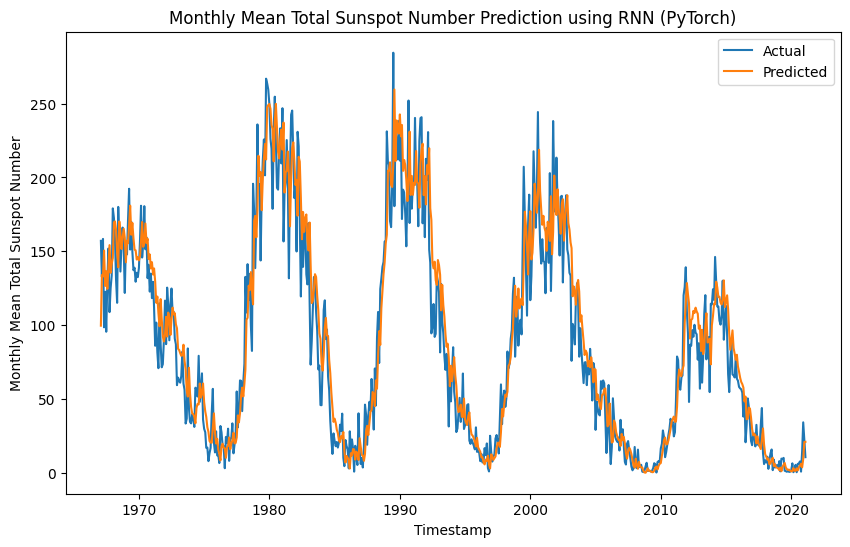

In [ ]:
# Visualize predictions against actual data
plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size+seq_length:], y_test, label='Actual')
plt.plot(df.index[train_size+seq_length:], y_pred, label='Predicted')
plt.xlabel('Timestamp')
plt.ylabel('Monthly Mean Total Sunspot Number')
plt.title('Monthly Mean Total Sunspot Number Prediction using RNN (PyTorch)')
plt.legend()
plt.show()